This notebook is an exploration notebook with the use of the original MoAMA repo. It is not particularly clean up and not meant for sharing any particular information.

There might be some local data missing in the public repository

In [1]:
import pandas as pd
import torch
import numpy as np
torch.set_printoptions(precision=2, linewidth=200, sci_mode=False)
np.set_printoptions(precision=2, linewidth=140)
# from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

from torch_geometric.loader import DataLoader

from src.data import Zinc

In [2]:
zinc_smiles = pd.read_csv("data/datasets/zinc.csv", header=None)[0]

## Logic of the featurization of the Molecule 

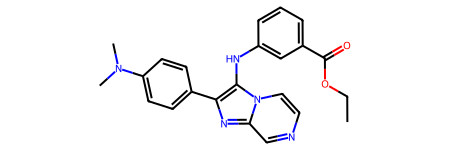

In [3]:
# Graph MAE utils to go from and to mols
from rdkit import Chem
import torch 
import numpy as np
from torch_geometric.data import Data

allowable_features = {
    'possible_atomic_num_list' : list(range(1, 119)),
    'possible_formal_charge_list' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'possible_chirality_list' : [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ],
    'possible_hybridization_list' : [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'possible_numH_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'possible_implicit_valence_list' : [0, 1, 2, 3, 4, 5, 6],
    'possible_degree_list' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'possible_bonds' : [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'possible_bond_dirs' : [ # only for double bond stereo information
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]
}

def mol_to_graph_data_obj_simple(mol):
    """
    Converts rdkit mol object to graph Data object required by the pytorch
    geometric package. NB: Uses simplified atom and bond features, and represent
    as indices
    :param mol: rdkit mol object
    :return: graph data object with the attributes: x, edge_index, edge_attr
    """
    # atoms
    num_atom_features = 2   # atom type,  chirality tag
    atom_features_list = []
    for atom in mol.GetAtoms():
        atom_feature = [allowable_features['possible_atomic_num_list'].index(
            atom.GetAtomicNum())] + [allowable_features[
            'possible_chirality_list'].index(atom.GetChiralTag())]
        atom_features_list.append(atom_feature)
    x = torch.tensor(np.array(atom_features_list), dtype=torch.long)

    # bonds
    num_bond_features = 2   # bond type, bond direction
    if len(mol.GetBonds()) > 0: # mol has bonds
        edges_list = []
        edge_features_list = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_feature = [allowable_features['possible_bonds'].index(
                bond.GetBondType())] + [allowable_features[
                                            'possible_bond_dirs'].index(
                bond.GetBondDir())]
            edges_list.append((i, j))
            edge_features_list.append(edge_feature)
            edges_list.append((j, i))
            edge_features_list.append(edge_feature)

        # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
        edge_index = torch.tensor(np.array(edges_list).T, dtype=torch.long)

        # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
        edge_attr = torch.tensor(np.array(edge_features_list),
                                 dtype=torch.long)
    else:   # mol has no bonds
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, num_bond_features), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=Chem.MolToSmiles(mol))

    return data

def graph_data_obj_to_mol_simple(data_x, data_edge_index, data_edge_attr):
    """
    Convert pytorch geometric data obj to rdkit mol object. NB: Uses simplified
    atom and bond features, and represent as indices.
    :param: data_x:
    :param: data_edge_index:
    :param: data_edge_attr
    :return:
    """
    mol = Chem.RWMol()

    # atoms
    atom_features = data_x.cpu().numpy()
    num_atoms = atom_features.shape[0]
    for i in range(num_atoms):
        atomic_num_idx, chirality_tag_idx = atom_features[i]
        atomic_num = allowable_features['possible_atomic_num_list'][atomic_num_idx]
        chirality_tag = allowable_features['possible_chirality_list'][chirality_tag_idx]
        atom = Chem.Atom(atomic_num)
        atom.SetChiralTag(chirality_tag)
        mol.AddAtom(atom)

    # bonds
    edge_index = data_edge_index.cpu().numpy()
    edge_attr = data_edge_attr.cpu().numpy()
    num_bonds = edge_index.shape[1]
    for j in range(0, num_bonds, 2):
        begin_idx = int(edge_index[0, j])
        end_idx = int(edge_index[1, j])
        bond_type_idx, bond_dir_idx = edge_attr[j]
        bond_type = allowable_features['possible_bonds'][bond_type_idx]
        bond_dir = allowable_features['possible_bond_dirs'][bond_dir_idx]
        mol.AddBond(begin_idx, end_idx, bond_type)
        # set bond direction
        new_bond = mol.GetBondBetweenAtoms(begin_idx, end_idx)
        new_bond.SetBondDir(bond_dir)

    # Chem.SanitizeMol(mol) # fails for COC1=CC2=C(NC(=N2)[S@@](=O)CC2=NC=C(
    # C)C(OC)=C2C)C=C1, when aromatic bond is possible
    # when we do not have aromatic bonds
    # Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_KEKULIZE)

    return mol

Chem.MolFromSmiles(zinc_smiles[0])
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[0]))
data, data.x.T, data.edge_attr.T
graph_data_obj_to_mol_simple(data.x, data.edge_index, data.edge_attr)

In [4]:
from typing import List, Tuple
from functools import partial

from rdkit import Chem
import torch
from torch_geometric.data import Data as TorchGeometricData

from src.featurizer.dgllife import (
    atom_type_one_hot,
    atom_chiral_tag_one_hot,
    bond_type_one_hot,
    bond_direction_one_hot,
)

class SimpleGraph2dFeaturizer:
    """
    Atom features: Atom type, Chirality type
    Edge features: Bond type, Bond direction
    """
    LIST_BOND_FEATURIZERS =  [lambda bond: [bond_type_one_hot(bond).index(True)], lambda bond: [bond_direction_one_hot(bond).index(True)]]
    
    ALLOW_ATOM_TYPES = list(range(1, 119))

    CHIRAL_TYPES = [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ]

    BOND_TYPES = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]

    BOND_DIR = [
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ]

    def _get_vertex_features(self, mol: Chem.Mol) -> List[List[float]]:
        return [self._featurize_atom(atom) for atom in mol.GetAtoms()]
    
    def _featurize_atom(self, atom: Chem.Atom) -> List[float]:
        return np.concatenate([featurizer(atom) for featurizer in self._list_atom_featurizers()])
    
    def _list_atom_featurizers(self):
     return [
            # lambda atom: [atom_type_one_hot(atom, allowable_set=self.allowed_atom_types, encode_unknown=False).index(True)],
            lambda atom: [atom.GetAtomicNum() - 1],
            lambda atom: [atom_chiral_tag_one_hot(atom).index(True)]
    ]

    def _get_edge_features(self, mol: Chem.Mol) -> Tuple[List[List[int]], List[List[float]]]:
        edge_indices, edge_attributes = [], []
        for bond in mol.GetBonds():
            i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            bond_features = self._featurize_bond(bond)

            edge_indices.extend([[i, j], [j, i]])
            edge_attributes.extend([bond_features] * 2)

        return edge_indices, edge_attributes
    
    def _featurize_bond(self, bond: Chem.Bond) -> List[float]:
        return np.concatenate([featurizer(bond) for featurizer in self.LIST_BOND_FEATURIZERS])

    def __call__(self, smiles: str) -> TorchGeometricData:
        mol = Chem.MolFromSmiles(smiles)
        
        atom_features = self._get_vertex_features(mol)
        atom_features = torch.LongTensor(atom_features).view(-1, len(atom_features[0]))

        edge_indices, edge_attributes = self._get_edge_features(mol)
        edge_indices = torch.tensor(edge_indices, dtype=torch.long).t()
        edge_attributes = torch.LongTensor(edge_attributes)

        return TorchGeometricData(x=atom_features, edge_index=edge_indices, edge_attr=edge_attributes, smiles=smiles)
    
    def decode(self, data: TorchGeometricData) -> Chem.Mol:
        mol = Chem.RWMol()

        # atoms
        atom_features = data.x.cpu().numpy()
        num_atoms = atom_features.shape[0]
        for i in range(num_atoms):
            atomic_num_idx, chirality_tag_idx = atom_features[i]
            atomic_num = self.ALLOW_ATOM_TYPES[int(atomic_num_idx)]
            chirality_tag = self.CHIRAL_TYPES[int(chirality_tag_idx)]
            atom = Chem.Atom(atomic_num)
            atom.SetChiralTag(chirality_tag)
            mol.AddAtom(atom)

        # bonds
        edge_index = data.edge_index.cpu().numpy()
        edge_attr = data.edge_attr.cpu().numpy()
        num_bonds = edge_index.shape[1]
        for j in range(0, num_bonds, 2):
            begin_idx = int(edge_index[0, j])
            end_idx = int(edge_index[1, j])
            bond_type_idx, bond_dir_idx = edge_attr[j]
            bond_type = self.BOND_TYPES[int(bond_type_idx)]
            bond_dir = self.BOND_DIR[int(bond_dir_idx)]
            mol.AddBond(begin_idx, end_idx, bond_type)
            # set bond direction
            new_bond = mol.GetBondBetweenAtoms(begin_idx, end_idx)
            new_bond.SetBondDir(bond_dir)

        return mol

## BRICS Logic of the mask creation

In [5]:
from rdkit.Chem import BRICS

def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])

    res = list(BRICS.FindBRICSBonds(mol))
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]])

    # break bonds between rings and non-ring atoms
    for c in cliques:
        if len(c) > 1:
            if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                cliques.remove(c)
                cliques.append([c[1]])
                breaks.append(c)
            if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                cliques.remove(c)
                cliques.append([c[0]])
                breaks.append(c)

    # select atoms at intersections as motif
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
            cliques.append([atom.GetIdx()])
            for nei in atom.GetNeighbors():
                if [nei.GetIdx(), atom.GetIdx()] in cliques:
                    cliques.remove([nei.GetIdx(), atom.GetIdx()])
                    breaks.append([nei.GetIdx(), atom.GetIdx()])
                elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                    cliques.remove([atom.GetIdx(), nei.GetIdx()])
                    breaks.append([atom.GetIdx(), nei.GetIdx()])
                cliques.append([nei.GetIdx()])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:
                cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques, edges


## Step by step decomposition of the above code

In [6]:
brics_decomp(Chem.MolFromSmiles(data.smiles))

([[0, 1],
  [5, 6, 7, 8, 9, 29],
  [11, 12, 22, 23, 24, 25, 26, 27, 28],
  [16, 20, 21, 13, 14, 15],
  [3],
  [2],
  [10],
  [17],
  [4],
  [18],
  [19]],
 [(4, 5),
  (5, 0),
  (6, 2),
  (6, 1),
  (7, 3),
  (4, 1),
  (2, 3),
  (4, 8),
  (7, 9),
  (7, 10)])

In [7]:
zinc_smiles[30]

'CC(C)n1cnc(S(=O)(=O)N[C@@H]2CCS(=O)(=O)C2)c1'

[((10, 7), ('5', '12')), ((10, 11), ('5', '15')), ((1, 3), ('8', '9'))]


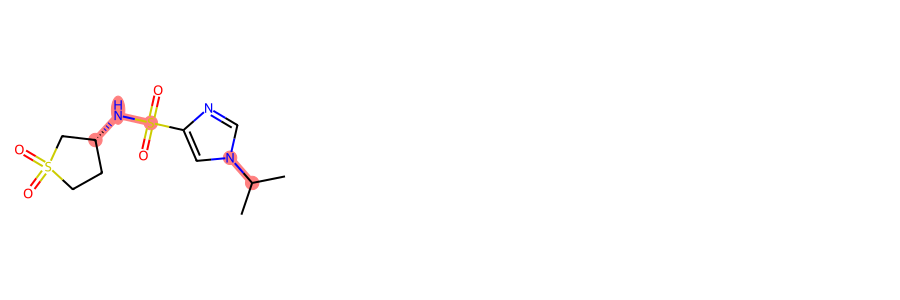

In [8]:
# In that case res and the FindBRICSBonds, The first element of each pair of tuple are the ids of the bond atom to remove 
# to get the separated BRICS motif
mol = Chem.MolFromSmiles(zinc_smiles[30])
res = list(BRICS.FindBRICSBonds(mol))
print(res)
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in res for b in a[0]]])

20 [[0, 1], [1, 2], [1, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [7, 9], [7, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [14, 16], [14, 17], [6, 18], [18, 3], [17, 11]]


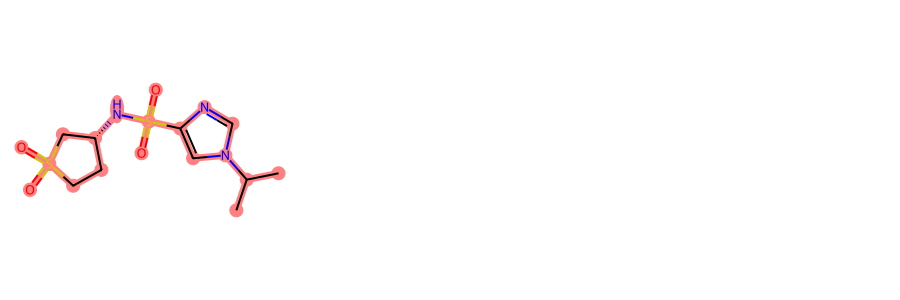

In [9]:
# Cliques is simply first all the bond present in a molecule
cliques = []
for bond in mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()
    cliques.append([a1, a2])
print(len(cliques), cliques)

Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in cliques for b in a]])

23 [[0, 1], [1, 2], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [7, 9], [11, 12], [12, 13], [13, 14], [14, 15], [14, 16], [14, 17], [6, 18], [18, 3], [17, 11], [10], [7], [10], [11], [1], [3]]


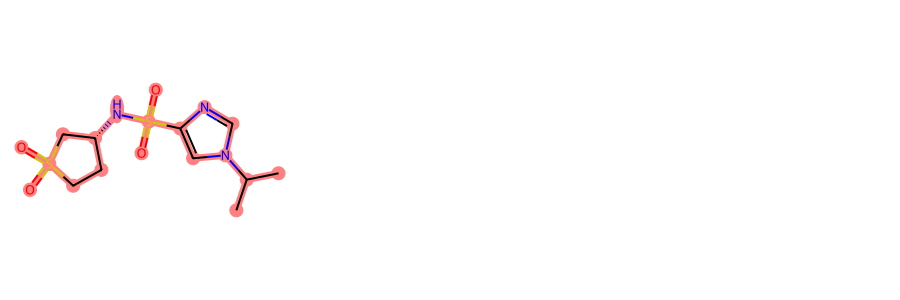

In [10]:
# In this step they remove the brics bond present in cliques.
# Not that cliques can have single atoms. In this case all the atom forming BRICS bond becomes single atoms 
for bond in res:
    if [bond[0][0], bond[0][1]] in cliques:
        cliques.remove([bond[0][0], bond[0][1]])
    else:
        cliques.remove([bond[0][1], bond[0][0]])
    cliques.append([bond[0][0]])
    cliques.append([bond[0][1]])
print(len(cliques), cliques)
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in cliques for b in a]])

In [11]:
cliques

[[0, 1],
 [1, 2],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [7, 9],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 15],
 [14, 16],
 [14, 17],
 [6, 18],
 [18, 3],
 [17, 11],
 [10],
 [7],
 [10],
 [11],
 [1],
 [3]]

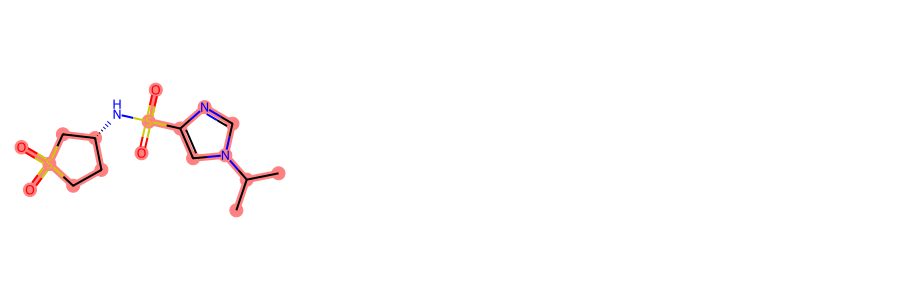

In [12]:
# Vizualization of the remaining bonds (tuple) in clique
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in cliques for b in a if len(a) > 1]])

In [13]:
mol.GetAtomWithIdx(14).IsInRing() and not mol.GetAtomWithIdx(16).IsInRing()

True

2 [[6, 7], [14, 15]]
23 [[0, 1], [1, 2], [3, 4], [4, 5], [5, 6], [7, 8], [7, 9], [11, 12], [12, 13], [13, 14], [14, 16], [14, 17], [6, 18], [18, 3], [17, 11], [10], [7], [10], [11], [1], [3], [7], [15]]


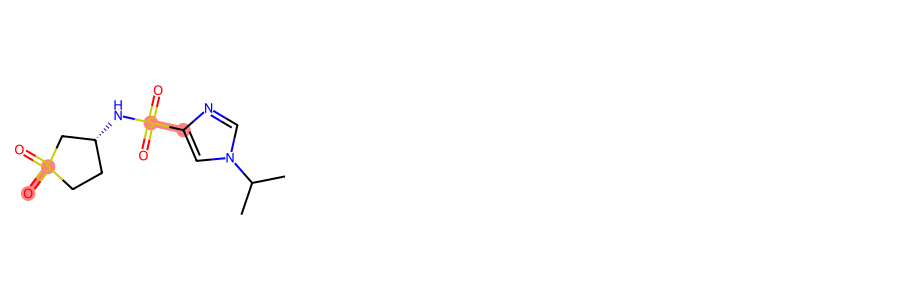

In [14]:
# Add bonds that are connecting to rings to the breaks if there are still some.
breaks = []
for c in cliques:
    if len(c) > 1:
        if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
            cliques.remove(c)
            cliques.append([c[1]])
            breaks.append(c)
        if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
            cliques.remove(c)
            cliques.append([c[0]])
            breaks.append(c)
print(len(breaks), breaks)
print(len(cliques), cliques)
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in breaks for b in a]])


In [15]:
mol.GetRingInfo().AtomRings()

((3, 4, 5, 6, 18), (12, 11, 17, 14, 13))

In [16]:
cliques

[[0, 1],
 [1, 2],
 [3, 4],
 [4, 5],
 [5, 6],
 [7, 8],
 [7, 9],
 [11, 12],
 [12, 13],
 [13, 14],
 [14, 16],
 [14, 17],
 [6, 18],
 [18, 3],
 [17, 11],
 [10],
 [7],
 [10],
 [11],
 [1],
 [3],
 [7],
 [15]]

4 [[0, 1], [1, 2], [7, 8], [7, 9]]
28 [[3, 4], [4, 5], [5, 6], [11, 12], [12, 13], [13, 14], [14, 16], [14, 17], [6, 18], [18, 3], [17, 11], [10], [7], [10], [11], [1], [3], [7], [15], [1], [0], [2], [3], [7], [6], [8], [9], [10]]


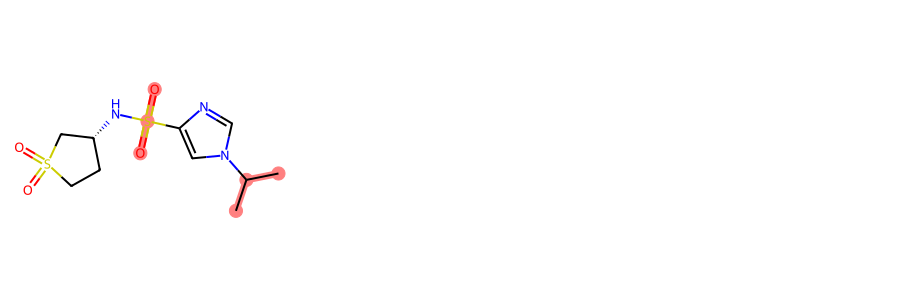

In [17]:
# Break all bonds which have more than 2 Neigbors outside of rings.
# Only chains bonds are kept.
breaks = []
for atom in mol.GetAtoms():
    if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
        cliques.append([atom.GetIdx()])
        for nei in atom.GetNeighbors():
            if [nei.GetIdx(), atom.GetIdx()] in cliques:
                cliques.remove([nei.GetIdx(), atom.GetIdx()])
                breaks.append([nei.GetIdx(), atom.GetIdx()])
            elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                cliques.remove([atom.GetIdx(), nei.GetIdx()])
                breaks.append([atom.GetIdx(), nei.GetIdx()])
            cliques.append([nei.GetIdx()])
print(len(breaks), breaks)
print(len(cliques), cliques)
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(300, 300), highlightAtomLists=[[b for a in breaks for b in a]])


[[3, 4], [4, 5], [5, 6], [11, 12], [12, 13], [13, 14], [14, 16], [14, 17], [6, 18], [18, 3], [17, 11]]


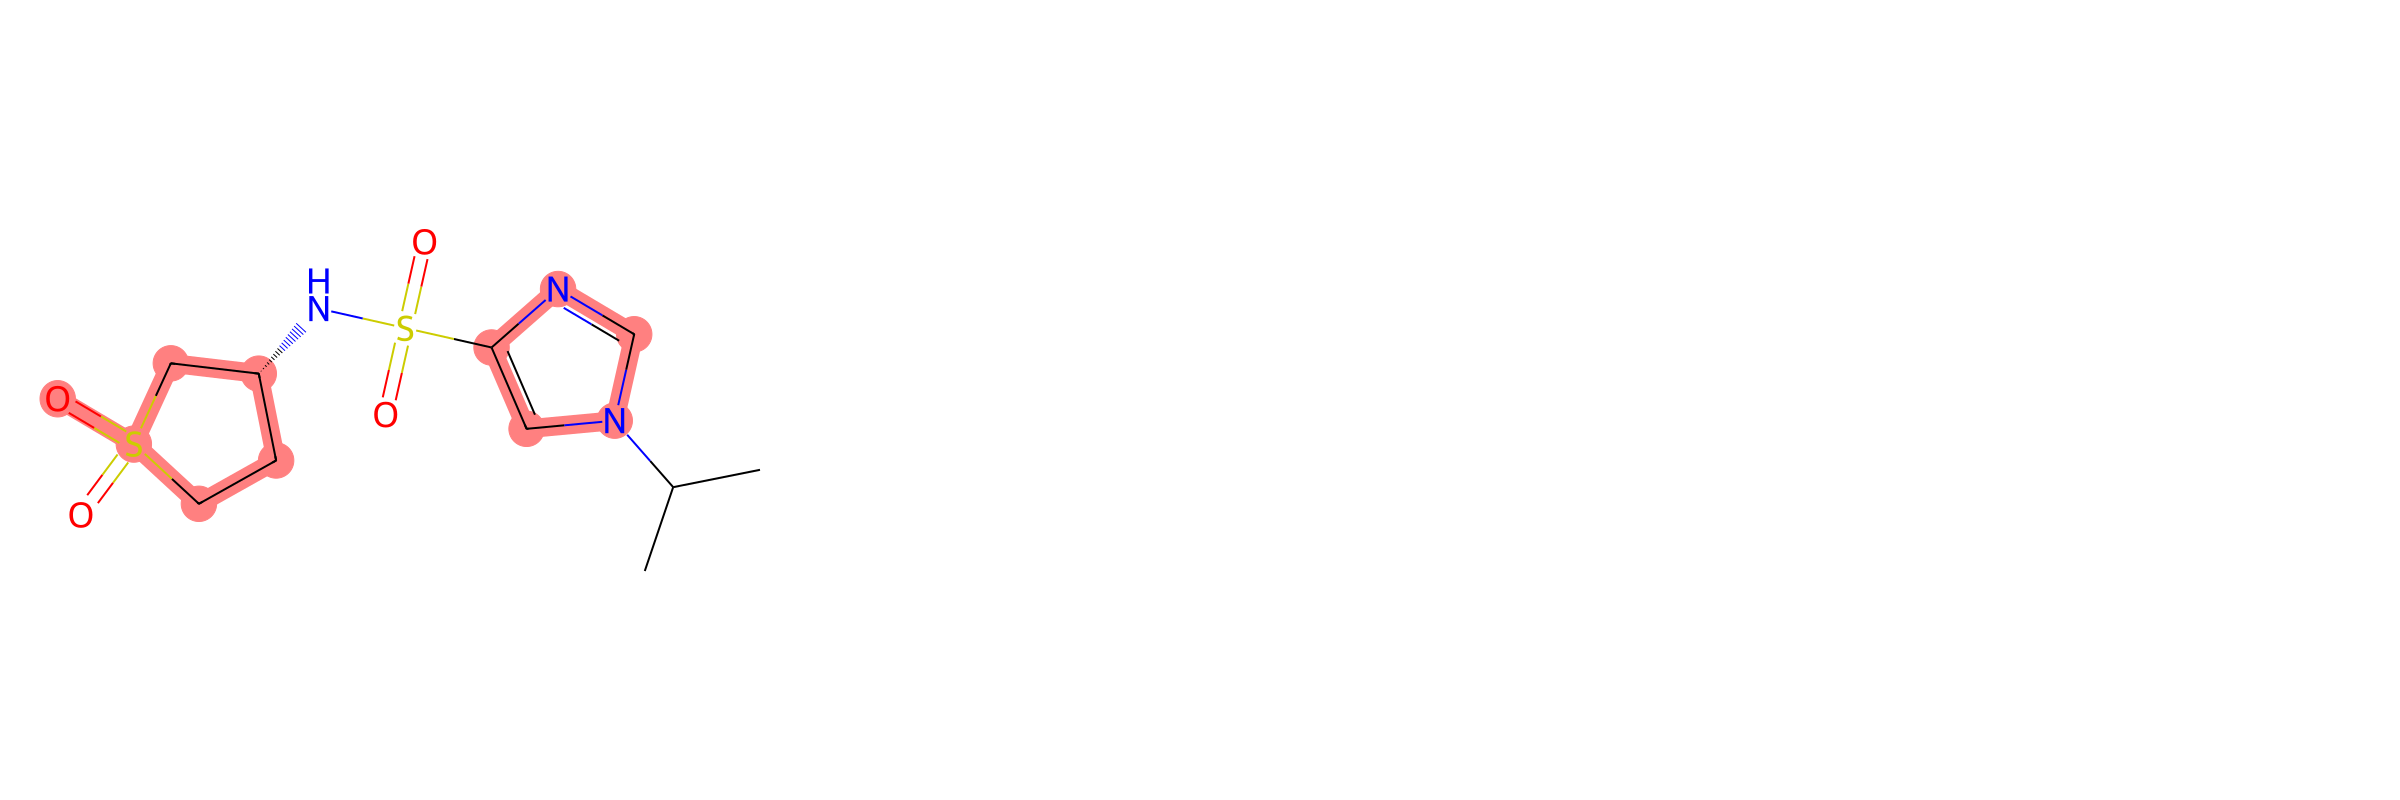

In [18]:
print([a for a in cliques if len(a) > 1])
Chem.Draw.MolsToGridImage(mols=[mol], subImgSize=(800, 800), highlightAtomLists=[[b for a in cliques for b in a  if len(a) > 1]])


10 [[18, 3, 4, 5, 6], [16, 17, 11, 12, 13, 14], [10], [7], [1], [15], [0], [2], [8], [9]]


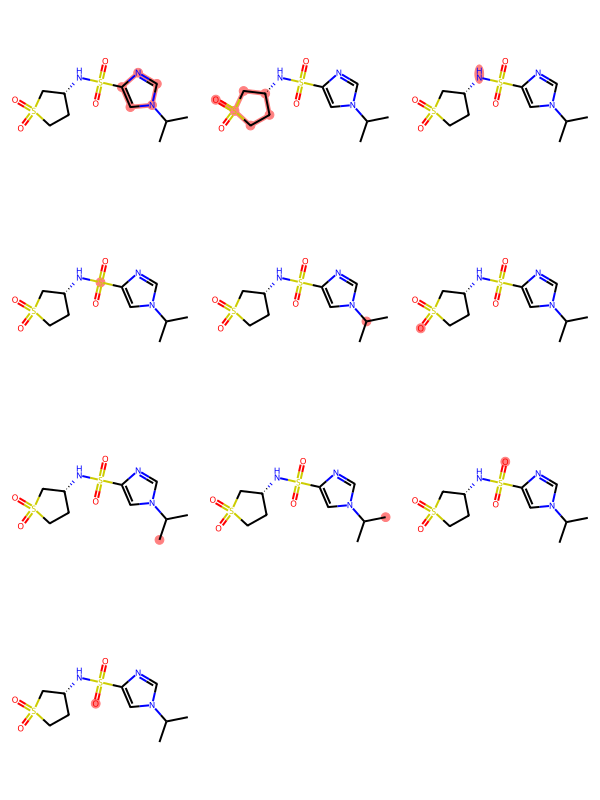

In [19]:
# Merge double, ie bonds element in clique together to create motifs. Other standalone atoms are kept.
for c in range(len(cliques) - 1):
    if c >= len(cliques):
        break
    for k in range(c + 1, len(cliques)):
        if k >= len(cliques):
            break
        if len(set(cliques[c]) & set(cliques[k])) > 0:
            cliques[c] = list(set(cliques[c]) | set(cliques[k]))
            cliques[k] = []
    cliques = [c for c in cliques if len(c) > 0]
cliques = [c for c in cliques if len(c) > 0]

print(len(cliques), cliques)
MolsToGridImage(mols=[mol] * len(cliques), subImgSize=(200, 200), highlightAtomLists=cliques)

## Analysis of the actual masking happening 

More info on the analysis here: 

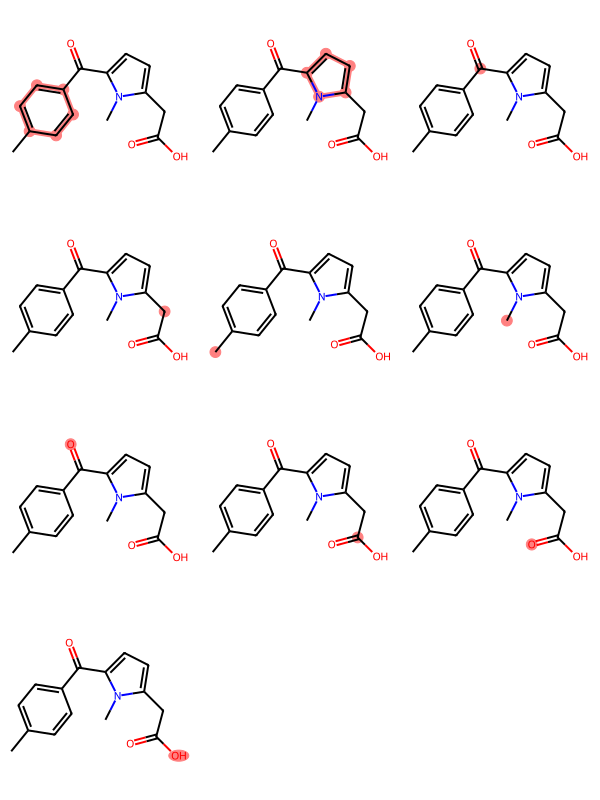

In [122]:
from rdkit.Chem.Draw import MolsToGridImage
smiles_id = 20
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[smiles_id]))
mol = Chem.MolFromSmiles(data.smiles)
atom_groups = brics_decomp(Chem.MolFromSmiles(data.smiles))
moama_motif = MolsToGridImage(mols=[mol] * len(atom_groups[0]), subImgSize=(200, 200), highlightAtomLists=atom_groups[0])
import math
moama_motif_ration = math.ceil(len(atom_groups[0]) / 3)
moama_motif

In [110]:
def remove_dummy_atom(piece: Chem.Mol):
    piece = Chem.rdchem.RWMol(piece)
    atoms = list(piece.GetAtoms())
    for atom in atoms:
        if atom.GetAtomicNum() == 0:
            piece.RemoveAtom(atom.GetIdx())
    return Chem.Mol(piece)

[(0, 1, 2, 3, 4, 17, 18), (5, 4, 3, 2, 1, 18, 17), (5, 6), (12, 13), (7, 8, 9, 10, 15, 16), (11, 12, 13, 14)]


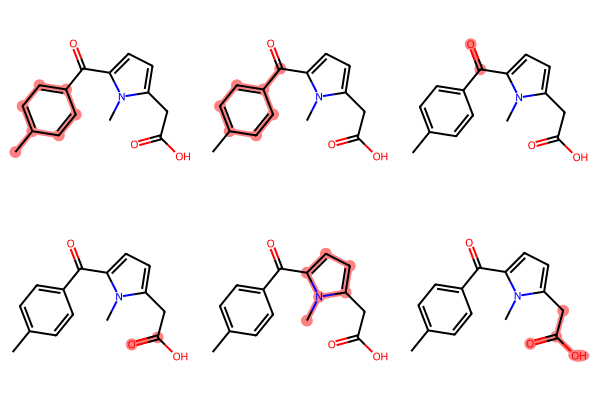

In [123]:
def to_keep(atom_group, ring_groups):
    is_ring_subset = not all([len(set(atom_group) - set(ring)) for ring in ring_groups])
    is_single_atom =  len(atom_group) == 1
    return  not (is_single_atom or is_ring_subset)

mol = Chem.MolFromSmiles(zinc_smiles[smiles_id])
fragmented=BRICS.BreakBRICSBonds(mol)
pieces=Chem.GetMolFrags(fragmented, asMols=True)
atom_groups = []
for piece in pieces:
    atom_groups.extend(mol.GetSubstructMatches(remove_dummy_atom(piece)))
ring_groups = mol.GetRingInfo().AtomRings()
atom_groups = [atom_group for atom_group in atom_groups if to_keep(atom_group, ring_groups)]
# atom_groups.extend(ring_groups)
print(atom_groups)
brics_img = MolsToGridImage(mols=[mol] * len(atom_groups), subImgSize=(200, 200), highlightAtomLists=atom_groups)
# Chem.Draw.MolsToGridImage(pieces)
brics_img_ratio = math.ceil(len(atom_groups) / 3)
brics_img

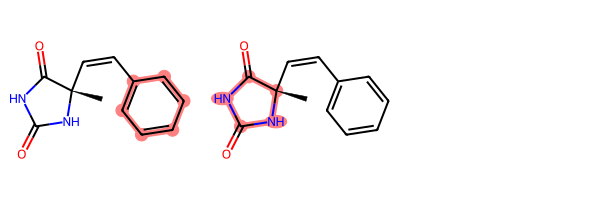

In [112]:
import importlib
import src.featurizer.motif_extractor
importlib.reload(src.featurizer.motif_extractor)
from src.featurizer.motif_extractor import BricsRingMotifExtractor
motifs = BricsRingMotifExtractor().get_motifs(mol)
atom_groups = [motif.atom_ids for motif in motifs]
MolsToGridImage(mols=[mol] * len(atom_groups), subImgSize=(200, 200), highlightAtomLists=atom_groups)


In [101]:
motifs

[Motif(atom_ids=(4, 5), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(7, 8, 9), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(14, 15), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(0, 1), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(9, 10), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(1, 2), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(22, 23, 21), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(7, 9), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(22, 23, 24), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(11, 12), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(2, 3, 4, 27, 28), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(11, 10, 21, 20, 13), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(16, 15, 19, 18, 17), neighbors_id=[], size_largest_parth=-1),
 Motif(atom_ids=(22, 24, 25, 26, 20, 21), neighbors_id=[23, 13, 10], size_largest_parth=3)]

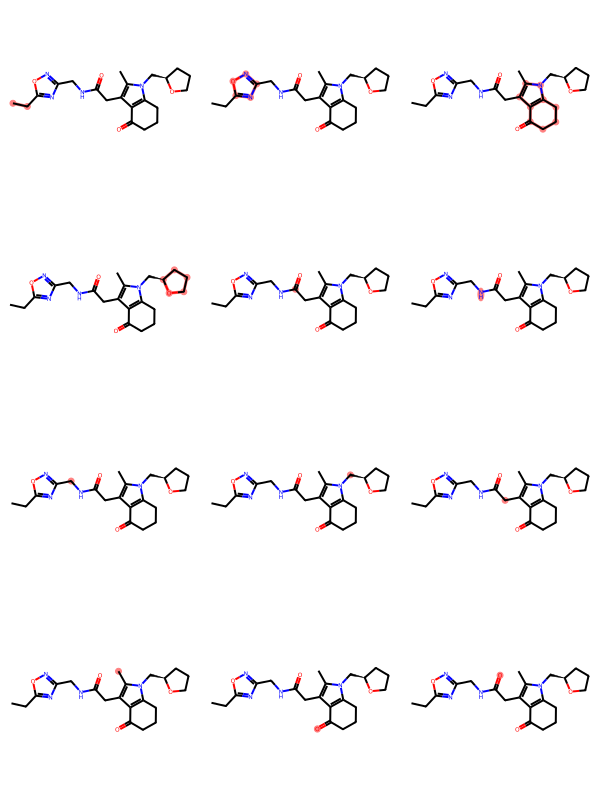

In [98]:
from src.featurizer.motif_extractor import MoaMAMotifExtractor
motifs = MoaMAMotifExtractor().get_motifs(mol)
atom_groups = [motif.atom_ids for motif in motifs]
MolsToGridImage(mols=[mol] * len(atom_groups), subImgSize=(200, 200), highlightAtomLists=atom_groups)


Cc1ccc(C(=O)c2ccc(CC(=O)O)n2C)cc1


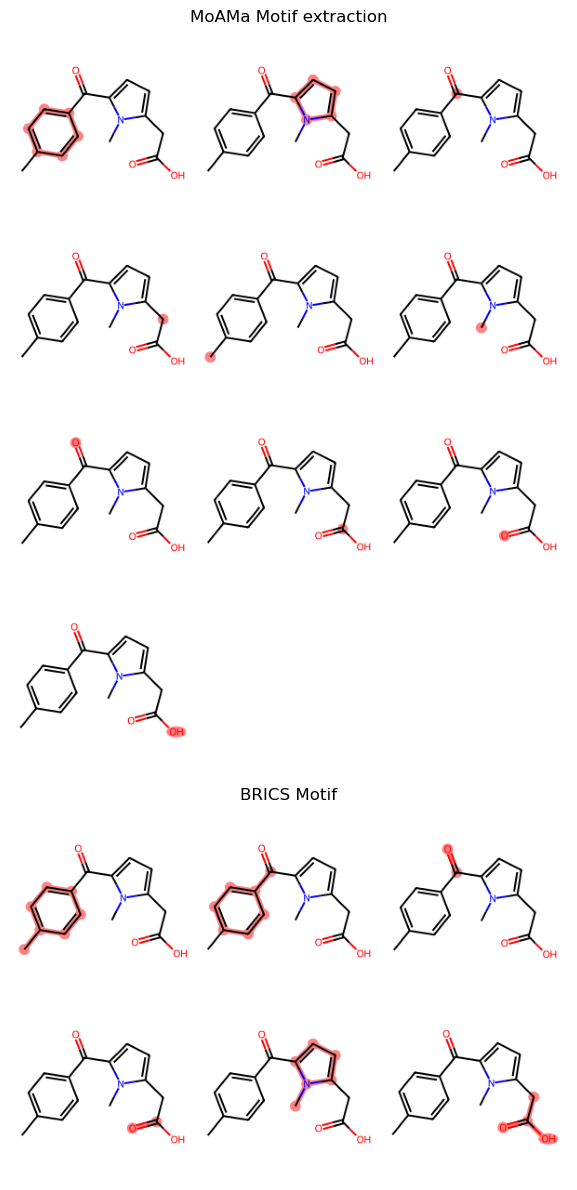

In [124]:
import io 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[moama_motif_ration, brics_img_ratio])


# Plot the first dataset
byte_io = io.BytesIO(moama_motif.data)
pil_moama_motif = Image.open(byte_io)
ax1 = plt.subplot(gs[0])
ax1.imshow(np.array(pil_moama_motif))
ax1.set_title("MoAMa Motif extraction")
ax1.axis('off')  # Hide axes

# Plot the second dataset
byte_io = io.BytesIO(brics_img.data)
ax2 = plt.subplot(gs[1])
pil_brics_img = Image.open(byte_io)
ax2.imshow(np.array(pil_brics_img))
ax2.set_title("BRICS Motif")
ax2.axis('off')  # Hide axes

print(Chem.MolToSmiles(mol))

# Adjust layout and display the figure
plt.tight_layout()

In [27]:
import matplotlib.pyplot as plt
# import io

# byte_io = io.BytesIO()
# img.save(byte_io, format='PNG')
# byte_io.seek(0)

# pil_img = Image.open(byte_io)

# np.array(img)
plt.imshow(np.array(img.convert("RGB")))

AttributeError: 'Image' object has no attribute 'convert'

In [159]:
set([1, 2, 3]) - set([1, 2, 3, 5])

set()

## Full atom generation with mask

In [31]:
# Original Mask Atom class from Authors
from itertools import count
from re import S
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from torch_geometric.data import Batch
from torch_geometric.data import Data

class MaskAtom:
    def __init__(
        self,
        num_atom_type,
        num_edge_type,
        mask_rate,
        inter_mask_rate,
        mask_strat,
        mask_edge,
    ):
        """
        Randomly masks an atom, and optionally masks edges connecting to it.
        The mask atom type index is num_possible_atom_type
        The mask edge type index in num_possible_edge_type
        :param num_atom_type:
        :param num_edge_type:
        :param mask_rate: % of atoms/motifs to be masked
        :param inter_mask_rate: % of atoms within motif to be masked
        :param mask_strat: node or element-wise masking
        :param mask_edge: If True, also mask the edges that connect to the
        masked atoms
        """
        self.num_atom_type = num_atom_type
        self.num_edge_type = num_edge_type
        self.mask_rate = mask_rate
        self.mask_edge = mask_edge

        self.num_chirality_tag = 3
        self.num_bond_direction = 3

        self.offset = 0

        self.inter_mask_rate = inter_mask_rate
        self.mask_strat = mask_strat

    def __call__(self, data, smiles, masked_atom_indices=None):
        """
        :param data: pytorch geometric data object. Assume that the edge
        ordering is the default pytorch geometric ordering, where the two
        directions of a single edge occur in pairs.
        Eg. data.edge_index = tensor([[0, 1, 1, 2, 2, 3],
                                     [1, 0, 2, 1, 3, 2]])
        :param masked_atom_indices: If None, then randomly samples num_atoms
        * mask rate number of atom indices
        Otherwise a list of atom idx that sets the atoms to be masked (for
        debugging only)
        :return: None, Creates new attributes in original data object:
        data.mask_node_idx
        data.mask_node_label
        data.mask_edge_idx
        data.mask_edge_label
        """

        mol = Chem.MolFromSmiles(smiles)
        motifs = get_motifs(mol)
        grouping = torch.tensor([0] * len(data.x[:, 1]))

        num_atoms = data.x.size()[0]
        sample_size = int(num_atoms * self.mask_rate + 1)

        valid_motifs = []
        if len(motifs) != 1:
            for motif in motifs:
                for atom in mol.GetAtoms():
                    if atom.GetIdx() in motif:
                        if inter_motif_proximity(motif, [atom], []) > 5:
                            break
                valid_motifs.append(motif)

        for i, x in enumerate(motifs):
            grouping[x] = i + self.offset

        self.offset += i

        masked_atom_indices = []

        # Select motifs according to
        while len(masked_atom_indices) < sample_size:
            if len(valid_motifs) < 1:
                index_list = random.sample(range(num_atoms), sample_size)
                for index in index_list:
                    if index not in masked_atom_indices:
                        masked_atom_indices.append(index)
            else:
                candidate = valid_motifs[
                    random.sample(range(0, len(valid_motifs)), 1)[0]
                ]
                valid_motifs.remove(candidate)
                for atom_idx in candidate:
                    for i, edge in enumerate(data.edge_index[0]):
                        if atom_idx == edge:
                            for motif in valid_motifs:
                                if data.edge_index[1][i].item() in motif:
                                    valid_motifs.remove(motif)

                if (
                    len(masked_atom_indices) + len(candidate)
                    > sample_size + 0.1 * num_atoms
                ):
                    continue
                for index in candidate:
                    masked_atom_indices.append(index)

        # random masking
        if masked_atom_indices == None:
            # sample x distinct atoms to be masked, based on mask rate. But
            # will sample at least 1 atom
            num_atoms = data.x.size()[0]
            sample_size = int(num_atoms * self.mask_rate + 1)
            masked_atom_indices = random.sample(range(num_atoms), sample_size)

        l = math.ceil(len(masked_atom_indices) * self.inter_mask_rate)

        masked_atom_indices_atom = random.sample(masked_atom_indices, l)
        masked_atom_indices_chi = random.sample(masked_atom_indices, l)

        # create mask node label by copying atom feature of mask atom
        # node-wise masking
        if self.mask_strat == "node":
            mask_node_labels_list = []
            for atom_idx in masked_atom_indices_atom:
                mask_node_labels_list.append(data.x[atom_idx].view(1, -1))

            data.mask_node_label = torch.cat(mask_node_labels_list, dim=0)
            data.masked_atom_indices_atom = torch.tensor(masked_atom_indices_atom)
            data.masked_atom_indices_chi = torch.tensor(masked_atom_indices_atom)

            atom_type = F.one_hot(
                data.mask_node_label[:, 0], num_classes=self.num_atom_type
            ).float()
            atom_chirality = F.one_hot(
                data.mask_node_label[:, 1], num_classes=self.num_chirality_tag
            ).float()
            data.node_attr_label = atom_type
            data.node_attr_chi_label = atom_chirality

        # element-wise masking
        elif self.mask_strat == "element":
            mask_atom_labels_list = []
            mask_chi_labels_list = []
            for atom_idx in masked_atom_indices_atom:
                mask_atom_labels_list.append(data.x[atom_idx].view(1, -1))
            for atom_idx in masked_atom_indices_chi:
                mask_chi_labels_list.append(data.x[atom_idx].view(1, -1))

            data.mask_atom_label = torch.cat(mask_atom_labels_list, dim=0)
            data.mask_chi_label = torch.cat(mask_chi_labels_list, dim=0)
            data.masked_atom_indices_atom = torch.tensor(masked_atom_indices_atom)
            data.masked_atom_indices_chi = torch.tensor(masked_atom_indices_chi)

            atom_type = F.one_hot(
                data.mask_atom_label[:, 0], num_classes=self.num_atom_type
            ).float()
            atom_chirality = F.one_hot(
                data.mask_chi_label[:, 1], num_classes=self.num_chirality_tag
            ).float()
            data.node_attr_label = atom_type
            data.node_attr_chi_label = atom_chirality

        for atom_idx in masked_atom_indices_atom:
            data.x[atom_idx] = torch.tensor(
                [self.num_atom_type, data.x[atom_idx][1]]
            )
        for atom_idx in masked_atom_indices_chi:
            data.x[atom_idx] = torch.tensor([data.x[atom_idx][0], 0])

        if self.mask_edge:
            # create mask edge labels by copying edge features of edges that are bonded to
            # mask atoms
            connected_edge_indices = []
            for bond_idx, (u, v) in enumerate(data.edge_index.cpu().numpy().T):
                for atom_idx in masked_atom_indices:
                    if (
                        atom_idx in set((u, v))
                        and bond_idx not in connected_edge_indices
                    ):
                        connected_edge_indices.append(bond_idx)

            if len(connected_edge_indices) > 0:
                # create mask edge labels by copying bond features of the bonds connected to
                # the mask atoms
                mask_edge_labels_list = []
                for bond_idx in connected_edge_indices[::2]:  # because the
                    # edge ordering is such that two directions of a single
                    # edge occur in pairs, so to get the unique undirected
                    # edge indices, we take every 2nd edge index from list
                    mask_edge_labels_list.append(data.edge_attr[bond_idx].view(1, -1))

                data.mask_edge_label = torch.cat(mask_edge_labels_list, dim=0)
                # modify the original bond features of the bonds connected to the mask atoms
                for bond_idx in connected_edge_indices:
                    data.edge_attr[bond_idx] = torch.tensor([self.num_edge_type, 0])

                data.connected_edge_indices = torch.tensor(connected_edge_indices[::2])
            else:
                data.mask_edge_label = torch.empty((0, 2)).to(torch.int64)
                data.connected_edge_indices = torch.tensor(connected_edge_indices).to(
                    torch.int64
                )

            edge_type = F.one_hot(
                data.mask_edge_label[:, 0], num_classes=self.num_edge_type
            ).float()
            bond_direction = F.one_hot(
                data.mask_edge_label[:, 1], num_classes=self.num_bond_direction
            ).float()
            data.edge_attr_label = torch.cat((edge_type, bond_direction), dim=1)
            # data.edge_attr_label = edge_type

        return data

    def __repr__(self):
        return (
            "{}(num_atom_type={}, num_edge_type={}, mask_rate={}, mask_edge={})".format(
                self.__class__.__name__,
                self.num_atom_type,
                self.num_edge_type,
                self.mask_rate,
                self.mask_edge,
            )
        )


def inter_motif_proximity(target_motif, neighbors, checked):
    """Recursively check if the atom is in the motif, and find the proximity of the first atom outside the motif"""
    new_neighbors = []
    for atom in neighbors:
        for nei in atom.GetNeighbors():
            if nei.GetIdx() in checked:
                continue
            new_neighbors.append(nei)
            if nei.GetIdx() not in target_motif:
                return 1
        checked.append(atom.GetIdx())
    return inter_motif_proximity(target_motif, new_neighbors, checked) + 1

def get_motifs(data):

    Chem.SanitizeMol(data)
    motifs, edges = brics_decomp(data)
    return motifs

In [38]:
# MotifMaskAtom class minimal reproduction from authors
from typing import List, Tuple
import random

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import numpy as np
from rdkit import Chem
from rdkit.Chem import BRICS


class MotifMaskAtom:
    def __init__(
        self,
        num_atom_type,
        num_edge_type,
        mask_rate,
        mask_strat,
        mask_edge,
    ):
        """
        Randomly masks an atom, and optionally masks edges connecting to it.
        The mask atom type index is num_possible_atom_type
        The mask edge type index in num_possible_edge_type
        :param num_atom_type:
        :param num_edge_type:
        :param mask_rate: % of atoms/motifs to be masked
        :param mask_strat: node or element-wise masking
        :param mask_edge: If True, also mask the edges that connect to the
        masked atoms
        """
        self.num_atom_type = num_atom_type
        self.num_edge_type = num_edge_type
        self.mask_rate = mask_rate
        self.mask_edge = mask_edge

        self.num_chirality_tag = 3
        self.num_bond_direction = 3

        self.mask_strat = mask_strat

    def __call__(self, data: Data, smiles: str, masked_atom_indices=None):
        """
        :param data: pytorch geometric data object. Assume that the edge
        ordering is the default pytorch geometric ordering, where the two
        directions of a single edge occur in pairs.
        Eg. data.edge_index = tensor([[0, 1, 1, 2, 2, 3],
                                     [1, 0, 2, 1, 3, 2]])
        :param masked_atom_indices: If None, then randomly samples num_atoms
        * mask rate number of atom indices
        Otherwise a list of atom idx that sets the atoms to be masked (for
        debugging only)
        :return: None, Creates new attributes in original data object:
        data.mask_node_idx
        data.mask_node_label
        data.mask_edge_idx
        data.mask_edge_label
        """

        mol = Chem.MolFromSmiles(smiles)
        motifs = MoMAMotifExtractor.get_motifs(mol)

        masked_atom_indices = self.get_motif_base_mask(data, motifs)
        masked_atom_indices = self.additional_random_atom_mask(data, masked_atom_indices)

        data.mask_node_label = data.x[masked_atom_indices]
        data.masked_atom_indices_atom = torch.tensor(masked_atom_indices)
        data.node_attr_label = F.one_hot(data.mask_node_label[:, 0], num_classes=self.num_atom_type).float()

        data.x[masked_atom_indices, 0] = self.num_atom_type
        return data

    def additional_random_atom_mask(self, data, masked_atom_indices):
        num_atoms = data.x.size(0)
        sample_size = int(num_atoms * self.mask_rate + 1)
        if len(masked_atom_indices) < sample_size:
            remaining_atoms = set(range(num_atoms)) - set(masked_atom_indices)
            random_masked_atoms = random.sample(remaining_atoms, sample_size - len(masked_atom_indices))
            masked_atom_indices.extend(random_masked_atoms)
        return masked_atom_indices

    def get_random_mask(self, data: Data, sample_size):
        num_atoms = data.x.size(0)
        sample_size = int(num_atoms * self.mask_rate + 1)
        return random.sample(range(num_atoms), sample_size)

    def get_motif_base_mask(self, data: Data, motifs: List[List[int]]):
        num_atoms = data.x.size(0)
        sample_size = int(num_atoms * self.mask_rate + 1)
        masked_atom_indices = []
        src, dst = data.edge_index
        while len(masked_atom_indices) < sample_size and len(motifs):
            candidate = motifs.pop(random.randint(0, len(motifs) - 1))
            candidate_neighboring_atoms = set(dst[np.isin(src, candidate)].tolist())
            motifs = [motif for motif in motifs if not self.is_neighboring_motif(motif, candidate_neighboring_atoms)]

            if len(masked_atom_indices) + len(candidate) > sample_size + 0.1 * num_atoms:
                continue
            masked_atom_indices.extend(candidate)
        return masked_atom_indices

    def is_neighboring_motif(self, motif, candidate_neighboring_atoms):
        return len(set(motif) & candidate_neighboring_atoms)

    def __repr__(self):
        return "{}(num_atom_type={}, num_edge_type={}, mask_rate={}, mask_edge={})".format(
            self.__class__.__name__,
            self.num_atom_type,
            self.num_edge_type,
            self.mask_rate,
            self.mask_edge,
        )


class MoMAMotifExtractor:

    @staticmethod
    def get_motifs(mol: Chem.Mol) -> List[List[int]]:
        Chem.SanitizeMol(mol)
        motifs = MoMAMotifExtractor.brics_decomp(mol)
        return MoMAMotifExtractor.filter_large_motif(mol, motifs)

    @staticmethod
    def filter_large_motif(mol: Chem.Mol, motifs: List[List[int]], k_hop: int = 5) -> List[List[int]]:
        """Each node within the motif must be within a k-hop neighborhood
        (k equals number of GNN layers) of an inter-motif node"""
        valid_motifs = []
        if len(motifs) != 1:
            for motif in motifs:
                for atom in mol.GetAtoms():
                    if atom.GetIdx() in motif:
                        if MoMAMotifExtractor.inter_motif_proximity(motif, [atom], []) > k_hop:
                            break
                valid_motifs.append(motif)
        return valid_motifs

    @staticmethod
    def inter_motif_proximity(target_motif: List[int], neighbors: List[int], checked: List[int]) -> bool:
        """Recursively check if the atom is in the motif, and find the proximity of the first atom outside the motif"""
        new_neighbors = []
        for atom in neighbors:
            for nei in atom.GetNeighbors():
                if nei.GetIdx() in checked:
                    continue
                new_neighbors.append(nei)
                if nei.GetIdx() not in target_motif:
                    return 1
            checked.append(atom.GetIdx())
        return MoMAMotifExtractor.inter_motif_proximity(target_motif, new_neighbors, checked) + 1

    @staticmethod
    def brics_decomp(mol: Chem.Mol) -> List[List[int]]:
        """
        Not literally a BRICS decomposition. Most of the motif are removed only
        chain with no close R-group or Ring are kept intact. The rest are standalone atoms.
        """

        def break_brics_bond_from_cliques(brics_bonds: List[Tuple[int, int]], cliques: List[List[int]]) -> None:
            """In this step they remove the brics bond present in cliques.
            Note that bonds means tuple in clique and that cliques can have single atoms.
            In this case all the atom forming BRICS bond becomes single atoms
            """
            for src, dst in brics_bonds:
                if [src, dst] in cliques:
                    cliques.remove([src, dst])
                else:
                    cliques.remove([dst, src])
                cliques.append([src])
                cliques.append([dst])

        def break_bonds_connected_to_rings_from_clique(
            mol: Chem.Mol, cliques: List[List[int]], breaks: List[List[int]]
        ) -> None:
            """Break bonds between rings and non-ring atoms. Keep the atom outside the ring."""
            for c in cliques:
                if len(c) > 1:
                    if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                        cliques.remove(c)
                        cliques.append([c[1]])
                        breaks.append(c)
                    if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                        cliques.remove(c)
                        cliques.append([c[0]])
                        breaks.append(c)

        def break_bonds_outside_of_rings_from_clique(
            mol: Chem.Mol, cliques: List[List[int]], breaks: List[List[int]]
        ) -> None:
            """
            Original comment: select atoms at intersections as motif
            Break all bonds which have more than 2 neigbors outside of rings.
            Only chain bonds away from anyother R-group are kept.
            Basically most of the BRICS motif if remove outside the Ring
            see https://github.com/einae-nd/MoAMa-dev/issues/3
            """
            for atom in mol.GetAtoms():
                if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
                    cliques.append([atom.GetIdx()])
                    for nei in atom.GetNeighbors():
                        if [nei.GetIdx(), atom.GetIdx()] in cliques:
                            cliques.remove([nei.GetIdx(), atom.GetIdx()])
                            breaks.append([nei.GetIdx(), atom.GetIdx()])
                        elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                            cliques.remove([atom.GetIdx(), nei.GetIdx()])
                            breaks.append([atom.GetIdx(), nei.GetIdx()])
                        cliques.append([nei.GetIdx()])

        def merge_partial_motif_together(cliques: List[List[int]]) -> List[List[int]]:
            """Merge various motif together if they share an atom."""
            for c in range(len(cliques) - 1):
                if c >= len(cliques):
                    break
                for k in range(c + 1, len(cliques)):
                    if k >= len(cliques):
                        break
                    if len(set(cliques[c]) & set(cliques[k])) > 0:
                        cliques[c] = list(set(cliques[c]) | set(cliques[k]))
                        cliques[k] = []
                cliques = [c for c in cliques if len(c) > 0]
            cliques = [c for c in cliques if len(c) > 0]
            return cliques

        n_atoms = mol.GetNumAtoms()
        if n_atoms == 1:
            return [[0]], []

        cliques = [[bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx()] for bond in mol.GetBonds()]
        breaks = []

        brics_bonds = [bond_ids for bond_ids, _ in BRICS.FindBRICSBonds(mol)]
        if len(brics_bonds) == 0:
            return [list(range(n_atoms))], []
        else:
            break_brics_bond_from_cliques(brics_bonds, cliques)

        break_bonds_connected_to_rings_from_clique(mol, cliques, breaks)
        break_bonds_outside_of_rings_from_clique(mol, cliques, breaks)

        return merge_partial_motif_together(cliques)


In [42]:
random.seed(42)
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[5]))
mask_data = MaskAtom(119, 5, mask_rate=0.25, inter_mask_rate=1, mask_strat="node", mask_edge=False)(data.clone(), data.smiles)
mask_data

Data(x=[25, 2], edge_index=[2, 54], edge_attr=[54, 2], smiles='CCN(Cc1cnc(N2CCN(C)CC2)nc1)[C@H]1CCOC(C)(C)C1', mask_node_label=[8, 2], masked_atom_indices_atom=[8], masked_atom_indices_chi=[8], node_attr_label=[8, 119], node_attr_chi_label=[8, 3])

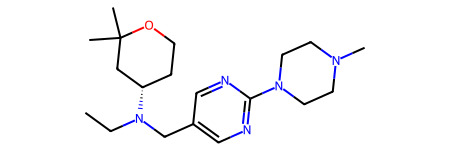

In [43]:
graph_data_obj_to_mol_simple(data.x, data.edge_index, data.edge_attr)

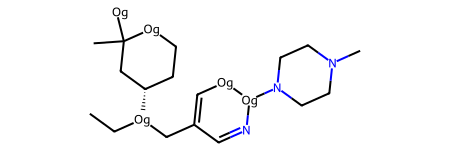

In [49]:
# for visualization of the mask part
random.seed(50)
mask_data = MaskAtom(117, 5, mask_rate=0.15, inter_mask_rate=1, mask_strat="node", mask_edge=False)(data.clone(), data.smiles)
mask_data
graph_data_obj_to_mol_simple(mask_data.x, data.edge_index, data.edge_attr)

In [52]:
random.seed(42)
data = mol_to_graph_data_obj_simple(Chem.MolFromSmiles(zinc_smiles[5]))
new_mask_data = MotifMaskAtom(119, 5, mask_rate=0.25, mask_strat="node", mask_edge=False)(data.clone(), data.smiles)
new_mask_data

Data(x=[25, 2], edge_index=[2, 54], edge_attr=[54, 2], smiles='CCN(Cc1cnc(N2CCN(C)CC2)nc1)[C@H]1CCOC(C)(C)C1', mask_node_label=[8, 2], masked_atom_indices_atom=[8], node_attr_label=[8, 119])

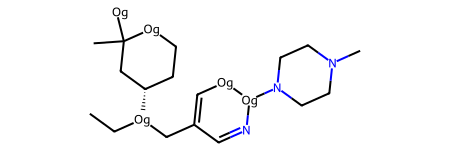

In [50]:
# for visualization of the mask part
random.seed(50)
new_mask_data = MaskAtom(117, 5, mask_rate=0.15, inter_mask_rate=1, mask_strat="node", mask_edge=False)(data.clone(), data.smiles)
new_mask_data
graph_data_obj_to_mol_simple(new_mask_data.x, data.edge_index, data.edge_attr)

In [46]:
import random
max([random.randint(0, len(a) - 1) for i in range(100)])

9

## Other techniques

Some test not really went far with it

In [35]:
import os, json, time
from tqdm import tqdm
from collections import defaultdict
from rdkit import Chem

PATT = {
    'HETEROATOM': '[!#6]',
    'DOUBLE_TRIPLE_BOND': '*=,#*',
    'ACETAL': '[CX4]([O,N,S])[O,N,S]'
}
PATT = {k: Chem.MolFromSmarts(v) for k, v in PATT.items()}


def get_fg_set(mol):
    """
    Identify FGs and convert to SMILES
    Args:
        mol:
    Returns: a set of FG's SMILES
    """
    fgs = []  # Function Groups

    # <editor-fold desc="identify and merge rings">
    rings = [set(x) for x in Chem.GetSymmSSSR(mol)]  # get simple rings
    flag = True  # flag == False: no rings can be merged
    while flag:
        flag = False
        for i in range(len(rings)):
            if len(rings[i]) == 0: continue
            for j in range(i + 1, len(rings)):
                shared_atoms = rings[i] & rings[j]
                if len(shared_atoms) > 2:
                    rings[i].update(rings[j])
                    rings[j] = set()
                    flag = True
    rings = [r for r in rings if len(r) > 0]
    # </editor-fold>

    # <editor-fold desc="identify functional atoms and merge connected ones">
    marks = set()
    for patt in PATT.values():  # mark functional atoms
        for sub in mol.GetSubstructMatches(patt):
            marks.update(sub)
    atom2fg = [[] for _ in range(mol.GetNumAtoms())]  # atom2fg[i]: list of i-th atom's FG idx
    for atom in marks:  # init: each marked atom is a FG
        fgs.append({atom})
        atom2fg[atom] = [len(fgs)-1]
    for bond in mol.GetBonds():  # merge FGs
        if bond.IsInRing(): continue
        a1, a2 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if a1 in marks and a2 in marks:  # a marked atom should only belong to a FG, if atoms are both marked, merge their FGs into a FG
            assert a1 != a2
            assert len(atom2fg[a1]) == 1 and len(atom2fg[a2]) == 1
            # merge a2' FG to a1's FG
            fgs[atom2fg[a1][0]].update(fgs[atom2fg[a2][0]])
            fgs[atom2fg[a2][0]] = set()
            atom2fg[a2] = atom2fg[a1]
        elif a1 in marks:  # only one atom is marked, add neighbour atom to its FG as its environment
            assert len(atom2fg[a1]) == 1
            # add a2 to a1's FG
            fgs[atom2fg[a1][0]].add(a2)
            atom2fg[a2].extend(atom2fg[a1])
        elif a2 in marks:
            # add a1 to a2's FG
            assert len(atom2fg[a2]) == 1
            fgs[atom2fg[a2][0]].add(a1)
            atom2fg[a1].extend(atom2fg[a2])
        else:  # both atoms are unmarked, i.e. a trivial C-C single bond
            # add single bond to fgs
            fgs.append({a1, a2})
            atom2fg[a1].append(len(fgs)-1)
            atom2fg[a2].append(len(fgs)-1)

    tmp = []
    for fg in fgs:
        if len(fg) == 0: continue
        if len(fg) == 1 and mol.GetAtomWithIdx(list(fg)[0]).IsInRing(): continue
        tmp.append(fg)
    fgs = tmp
    # </editor-fold>

    fgs.extend(rings)  # final FGs: rings + FGs (not in rings)

    fg_smiles = set()
    for fg in fgs:
        fg_smiles.add(Chem.MolFragmentToSmiles(mol, fg))

    return fg_smiles

[23:27:47] non-ring atom 0 marked aromatic
[23:27:47] non-ring atom 0 marked aromatic


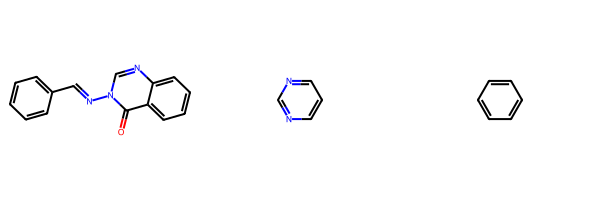

In [36]:
fg = get_fg_set(mol)
MolsToGridImage(mols= [mol] + list(filter(None, [Chem.MolFromSmiles(m) for m in fg])))

In [37]:
fg

{'c1ccccc1', 'c1cncnc1', 'c=O', 'cC=Nn'}

In [39]:
list(Chem.GetSymmSSSR(mol))

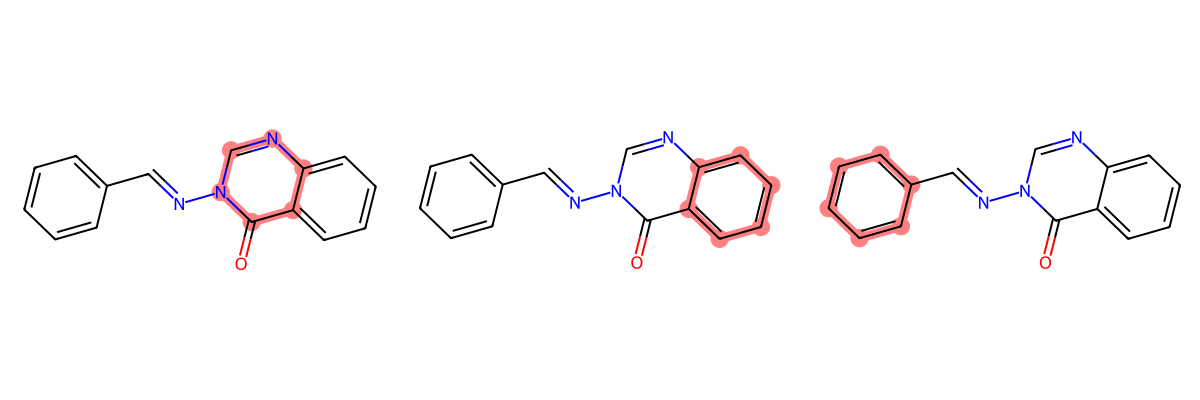

In [40]:
atom_groups = [list(a) for a in list(Chem.GetSymmSSSR(mol))]
MolsToGridImage(mols=[mol] * len(atom_groups), subImgSize=(400, 400), highlightAtomLists=atom_groups)

In [41]:
list(Chem.GetSymmSSSR(mol))

In [43]:
marks = set()
for patt in PATT.values():  # mark functional atoms
    for sub in mol.GetSubstructMatches(patt):
        marks.update(sub)

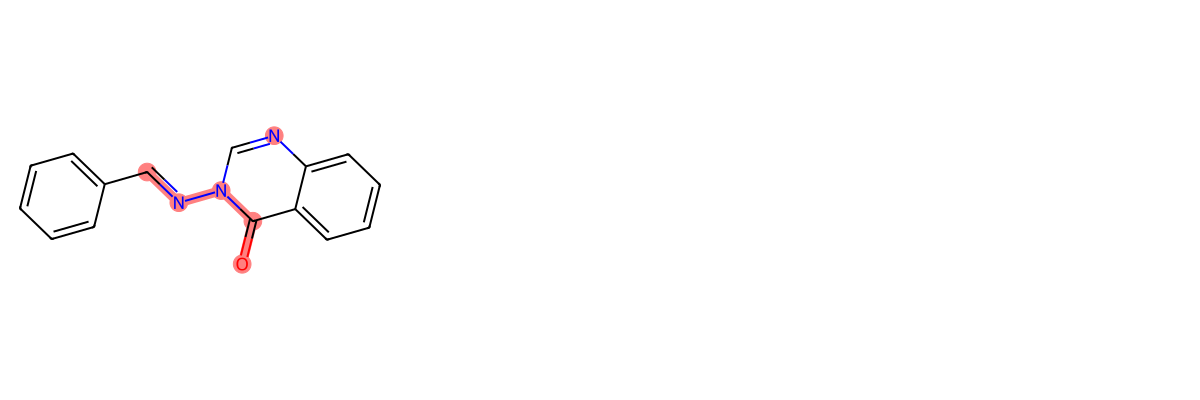

In [44]:
MolsToGridImage(mols=[mol], subImgSize=(400, 400), highlightAtomLists=[list(marks)])

In [45]:
from rdkit.Chem.FilterCatalog import GetFunctionalGroupHierarchy
functionalGroups = GetFunctionalGroupHierarchy()
[match.filterMatch.GetName() for match in functionalGroups.GetFilterMatches(Chem.MolFromSmiles('c1ccccc1Cl'))]


['Halogen.Aromatic', 'Halogen.NotFluorine.Aromatic']

In [46]:
functionalGroups.GetFilterMatches(Chem.MolFromSmiles('c1ccccc1Cl'))[0].atomPairs[0].query

0

In [47]:
functionalGroups.GetFilterMatches(Chem.MolFromSmiles('c1ccccc1Cl'))[0].atomPairs

In [48]:
mol = Chem.MolFromSmiles(zinc_smiles[5])
list(functionalGroups.GetFilterMatches(mol))
[[atom_pairs.query, atom_pairs.target] for match in functionalGroups.GetFilterMatches(mol) for atom_pairs in match.atomPairs]


[[0, 2], [0, 8], [0, 2], [0, 8]]

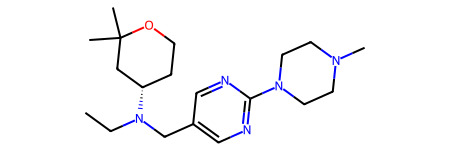

In [69]:
mol

## Analysis of Loss Aux

In [1]:
import json
import torch
from rdkit import Chem, DataStructs


with open("test_smiles.json", "r") as file:
    smiles = json.load(file)
embedding = torch.load("test_embedding.pt")

In [9]:
mols = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)).GetOnBits() for smi in smiles]

In [20]:
import torch
features = torch.zeros(2048, dtype=torch.uint8)

In [21]:
features[mols[0]] = 1

In [22]:
features

tensor([1, 1, 0,  ..., 1, 0, 1], dtype=torch.uint8)

In [31]:
"".join(map(str, features.tolist()))

'110011010011000010011000001011001011110111110100111100000110000001010110010001000111000000110000101001111001000010000100011101010000000000110011000000100100010101000010111100010111110100010000011000110001100010100010000101010011001110101100000000111001111110000010010111001000010010111100000000100000100001001000110001111000101101110000100100000100100000011100000100010000000001000011001110100000011010110010111111000100000100000110100010100100001000000000100010110100111111000111000000110010110011100000001000010110100000101111110000100000000110000000011110000110100011010100100110010100000010000000111111001110010001001100101100101100000011001001101000011011000010100000001110100000101100000011000110101000010100000000000000000110010001000110101000101011000011101100000010100010101001100111100010110011000110101000011101101111001010101111111010100000011111011000101000101000100101010010101011000010100100100010101000100010010100110010001101000000101101011000001010110101000101110111111000101000011

In [64]:
# %%timeit
fingerprint_list = []
oldfingerprint_loss = 0
for i in range(len(embedding)):
    mol = Chem.RDKFingerprint(Chem.MolFromSmiles(smiles[i]))
    for j in range(len(fingerprint_list)):
        finger_sim = DataStructs.FingerprintSimilarity(mol, fingerprint_list[j])
        emb_sim = (embedding[i].dot(embedding[j])) / (torch.linalg.norm(embedding[i]) * torch.linalg.norm(embedding[j]))
        oldfingerprint_loss += (finger_sim - emb_sim) ** 2

    fingerprint_list.append(mol)

In [8]:
# %%timeit

fingerprint_loss = []
for i in range(len(embedding)):
    for j in range(i):
        finger_sim = DataStructs.FingerprintSimilarity(mols[i], mols[j])
        emb_sim = (embedding[i].dot(embedding[j])) / (torch.linalg.norm(embedding[i]) * torch.linalg.norm(embedding[j]))
        fingerprint_loss.append((finger_sim - emb_sim) ** 2)


In [27]:
%%timeit

fingerprints = torch.zeros([len(mols), len(mols)], device="cuda:1")
for i in range(len(mols)):
    for j in range(i):
        fingerprints[i, j] = DataStructs.FingerprintSimilarity(mols[i], mols[j])

322 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%timeit

fingerprints = np.zeros([len(mols), len(mols)])
for i in range(len(mols)):
    fingerprints[i, :i] = DataStructs.BulkTanimotoSimilarity(mols[i], mols[:i])
    
fingerprints = torch.from_numpy(fingerprints)

3.61 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
# %%timeit
sim_cos = torch.nn.CosineSimilarity()

for i in range(len(mols)):
    emb_sim = sim_cos(embedding[None, i], embedding[:i])
    fingerprint_loss.extend(((fingerprints[i, :i] - emb_sim)**2))

74 ms ± 9.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit
mols = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in smiles]

fingerprints = np.zeros([len(mols), len(mols)])
for i in range(len(mols)):
    fingerprints[i, :i] = DataStructs.BulkTanimotoSimilarity(mols[i], mols[:i])
    
fingerprints = torch.from_numpy(fingerprints).to(device="cuda:1")
        
sim_cos = torch.nn.CosineSimilarity()

fingerprint_loss = 0 
for i in range(len(mols)):
    emb_sim = sim_cos(embedding[None, i], embedding[:i])
    fingerprint_loss += ((fingerprints[i, :i] - emb_sim)**2).sum()

427 ms ± 70.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
# %%timeit
mols = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in smiles]

fingerprints = torch.zeros([len(mols), len(mols)], device="cuda:1")
for i in range(len(mols)):
    for j in range(i):
        fingerprints[i, j] = DataStructs.FingerprintSimilarity(mols[i], mols[j])
        
sim_cos = torch.nn.CosineSimilarity()

fingerprint_loss = 0 
for i in range(len(mols)):
    emb_sim = sim_cos(embedding[None, i], embedding[:i])
    fingerprint_loss += ((fingerprints[i, :i] - emb_sim)**2).sum()

AttributeError: 'numpy.ndarray' object has no attribute 'GetNumBits'

## New Motif Extractor

In [1]:
from typing import List
from rdkit import Chem
from rdkit.Chem import BRICS

class BricsRingMotifExtractor:

    @staticmethod
    def to_keep(atom_group, ring_groups):
        is_ring_subset = not all([len(set(atom_group) - set(ring)) for ring in ring_groups])
        is_single_atom = len(atom_group) == 1
        return not (is_single_atom or is_ring_subset)

    @staticmethod
    def get_motifs(mol: Chem.Mol) -> List[List[int]]:
        fragmented = BRICS.BreakBRICSBonds(mol)
        pieces = Chem.GetMolFrags(fragmented, asMols=True)
        atom_groups = []
        for piece in pieces:
            atom_groups.extend(mol.GetSubstructMatches(BricsRingMotifExtractor.remove_dummy_atoms(piece)))
        ring_groups = mol.GetRingInfo().AtomRings()
        atom_groups = [
            atom_group for atom_group in atom_groups if BricsRingMotifExtractor.to_keep(atom_group, ring_groups)
        ]
        atom_groups.extend(ring_groups)
        return atom_groups

    @staticmethod
    def remove_dummy_atoms(mol: Chem.Mol) -> Chem.Mol:
        mol = Chem.rdchem.RWMol(mol)
        atoms = list(mol.GetAtoms())
        for atom in atoms:
            if atom.GetAtomicNum() == 0:
                mol.RemoveAtom(atom.GetIdx())
        return Chem.Mol(mol)

[(0, 1, 2, 3, 4, 5, 19, 20, 21, 22, 23), (6, 7, 8), (10, 11, 12, 13, 14, 15, 16, 17, 18), (1, 21, 19, 5, 3, 2), (11, 10, 18, 17, 12), (13, 14, 15, 16, 17, 12)]


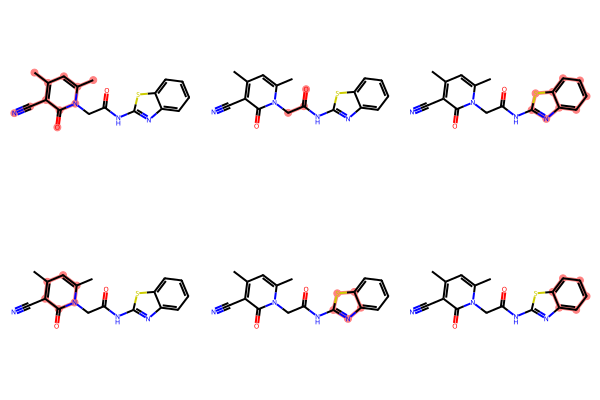

In [43]:
smiles_id = 17
mol = Chem.MolFromSmiles(zinc_smiles[smiles_id])
atom_groups = BricsRingMotifExtractor.get_motifs(mol)
print(atom_groups)
MolsToGridImage(mols=[mol] * len(atom_groups), subImgSize=(200, 200), highlightAtomLists=atom_groups)

In [ ]:

def get_submolecule(mol: Chem.Mol, atom_indices):
    # Create an editable molecule based on the original molecule
    emol = Chem.EditableMol(Chem.Mol())

    # Map to store the mapping from old atom index to new atom index
    old_to_new = {}

    # Add the atoms specified by atom_indices to the new molecule
    for i, idx in enumerate(atom_indices):
        atom = mol.GetAtomWithIdx(idx)
        atom.Get
        new_idx = emol.AddAtom(atom)
        old_to_new[idx] = new_idx

    # Add the bonds between the specified atoms to the new molecule
    for bond in mol.GetBonds():
        begin_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        if begin_atom in atom_indices and end_atom in atom_indices:
            emol.AddBond(old_to_new[begin_atom], old_to_new[end_atom], bond.GetBondType())

    # Get the submolecule
    submol = emol.GetMol()

    return submol

In [7]:
len((3, 4, 5, 6, 7, 8, 9, 18))

8

In [34]:
motif = (3, 4, 5, 6, 7, 8, 9, 18)
outside_motif_neigbors = []
for atom_id in motif:
    atom = mol.GetAtomWithIdx(atom_id)
    neighbors = set([nb.GetIdx() for nb in atom.GetNeighbors()]) - set(motif)
    if len(neighbors):
        outside_motif_neigbors.append(list(neighbors)[0])
    
outside_motif_neigbors

[1, 10]

In [79]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from copy import deepcopy
from dataclasses import dataclass

def get_motif_neigboring_atoms(mol, motif):
    motif_neigbors = []
    for atom_id in motif:
        atom = mol.GetAtomWithIdx(atom_id)
        neighbors = set([nb.GetIdx() for nb in atom.GetNeighbors()]) - set(motif)
        if len(neighbors):
            # Only one atom is enough
            motif_neigbors.append(list(neighbors)[0])
            
    return motif_neigbors
    

def get_largest_path(molecule, motif_atom_ids, motif_neighbors_ids):
    # Create a function to perform BFS and find the shortest path
    def get_shortest_path(mol, start_atom, target_atoms):
        visited = [False] * mol.GetNumAtoms()
        queue = [(start_atom, [start_atom])]
        visited[start_atom] = True
        
        while queue:
            current_atom, path = queue.pop(0)
            
            if current_atom in target_atoms:
                return len(path) - 1
            
            neighbors = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(current_atom).GetNeighbors()]
            for neighbor in neighbors:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append((neighbor, path + [neighbor]))
        
        return []

    motif_largest_path = 0

    for motif_atom in motif_atom_ids:
        atom_largest_path = 1e5
        
        for neighbor_atom in motif_neighbors_ids:
            shortest_path = get_shortest_path(molecule, motif_atom, [neighbor_atom])
            atom_largest_path =  min(atom_largest_path, shortest_path)
             
        motif_largest_path = max(motif_largest_path, atom_largest_path)

    return motif_largest_path

@dataclass
class Motif:
    atom_ids: List[int]
    neighbors_id: List[int]
    size_largest_parth: int

def filter_large_motifs(mol: Chem.Mol, motifs: List[List[int]]):
    valid_motifs = []
    for motif in motifs:
        if len(motif) > 5:
            motif_neighbors_ids = get_motif_neigboring_atoms(mol, motif)
            size_largest_path = get_largest_path(mol, motif, motif_neighbors_ids)
            if size_largest_path <= 5:
                valid_motifs.append(Motif(motif, motif_neighbors_ids, size_largest_path))
                
    return valid_motifs

# Example usage:
# smiles = 'CC(C)CC1=CC=CC=C1'  # Example SMILES
# molecule = Chem.MolFromSmiles(smiles)
# motif_atom_ids = [0, 1, 2]  # Example motif atom indices
# motif_neighbors_ids = [3, 4, 5]  # Example motif neighbor atom indices
# for motif_atom, shortest_paths in paths.items():
#     print(f"Motif atom {motif_atom} closest paths to neighbors:")
#     for neighbor_atom, path in shortest_paths.items():
#         print(f"  To neighbor atom {neighbor_atom}: Path {path}")

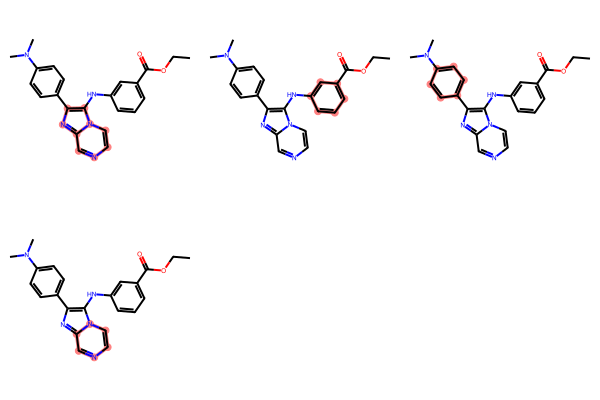

In [80]:
mol = Chem.MolFromSmiles("CCOC(=O)c1cccc(Nc2c(-c3ccc(N(C)C)cc3)nc3cnccn32)c1")
atom_groups = BricsRingMotifExtractor.get_motifs(mol)
motifs = filter_large_motifs(mol, atom_groups)
# atom_groups = [(11, 12, 22, 23, 24, 25, 26, 27, 28)]
MolsToGridImage(mols=[mol] * len(motifs), subImgSize=(200, 200), highlightAtomLists=[motif.atom_ids for motif in motifs])


In [81]:
motifs

[Motif(atom_ids=(11, 12, 22, 23, 24, 25, 26, 27, 28), neighbors_id=[10, 13], size_largest_parth=5),
 Motif(atom_ids=(5, 29, 9, 8, 7, 6), neighbors_id=[3, 10], size_largest_parth=3),
 Motif(atom_ids=(14, 15, 16, 20, 21, 13), neighbors_id=[17, 12], size_largest_parth=2),
 Motif(atom_ids=(24, 25, 26, 27, 28, 23), neighbors_id=[11, 22], size_largest_parth=3)]

In [17]:
fragmented = BRICS.BreakBRICSBonds(mol)
pieces = Chem.GetMolFrags(fragmented, asMols=True)
atom_groups = []
for piece in pieces:
    atom_groups.extend(mol.GetSubstructMatches(BricsRingMotifExtractor.remove_dummy_atoms(piece)))
ring_groups = mol.GetRingInfo().AtomRings()
atom_groups = [
    atom_group for atom_group in atom_groups if BricsRingMotifExtractor.to_keep(atom_group, ring_groups)
]
atom_groups.extend(ring_groups)

In [19]:
Chem.MolToSmiles(pieces[0])

'[8*]C(C)C'

In [121]:
from collections import deque
class BricsRingMotifExtractor:
    """
    Extract BRICS motifs as well as rings. If the motif is too large > 5 hop
    from the nearest neighbor, it is filter out
    """

    @classmethod
    def get_motifs(cls, mol: Chem.Mol) -> List[Motif]:
        motifs = cls.get_brics_motifs(mol)
        cls.add_ring_motif_and_delete_dupplicates(mol, motifs)
        return cls.filter_large_motifs(mol, motifs)

    @classmethod
    def get_brics_motifs(cls, mol: Chem.Mol):
        fragmented = BRICS.BreakBRICSBonds(mol)
        pieces = Chem.GetMolFrags(fragmented, asMols=True)
        motifs = []
        for piece in pieces:
            motifs.extend(mol.GetSubstructMatches(cls.remove_dummy_atoms(piece)))
        return list(set(motifs))

    @classmethod
    def add_ring_motif_and_delete_dupplicates(cls, mol: Chem.Mol, motifs: List[List[int]]):
        """Add all single ring as motif, some BRICS motif which are subset of ring are deleted."""
        ring_groups = mol.GetRingInfo().AtomRings()
        motifs = [motif for motif in motifs if cls.to_keep(motif, ring_groups)]
        motifs.extend(ring_groups)

    @classmethod
    def to_keep(cls, atom_group, ring_groups):
        is_ring_subset = not all([len(set(atom_group) - set(ring)) for ring in ring_groups])
        is_single_atom = len(atom_group) == 1
        return not (is_single_atom or is_ring_subset)

    @classmethod
    def remove_dummy_atoms(cls, mol: Chem.Mol) -> Chem.Mol:
        mol = Chem.rdchem.RWMol(mol)
        atoms = list(mol.GetAtoms())
        for atom in atoms:
            if atom.GetAtomicNum() == 0:
                mol.RemoveAtom(atom.GetIdx())
        return Chem.Mol(mol)

    @classmethod
    def filter_large_motifs(cls, mol: Chem.Mol, motifs: List[List[int]], k_hop: int = 5) -> List[Motif]:
        """Each node within the motif must be within a k-hop neighborhood
        (k equals number of GNN layers) of an inter-motif node
        """
        valid_motifs = []
        for motif in motifs:
            if len(motif) > k_hop:
                motif_neighbors_ids = cls.get_motif_neigboring_atoms(mol, motif)
                size_largest_path = cls.get_largest_path(mol, motif, motif_neighbors_ids)
                if size_largest_path <= k_hop:
                    valid_motifs.append(Motif(motif, motif_neighbors_ids, size_largest_path))

        return valid_motifs

    @classmethod
    def get_shortest_path(cls, mol: Chem.Mol, start_atom: int, target_atoms: int) -> int:
        """Get size of shortest path between start_atom and target_atoms, correspond
        to the number of edge between a atom outside the motif and an atom in the motif.
        """
        visited = set([start_atom])
        queue = [(start_atom, 0)]

        while queue:
            current_atom, distance = queue.pop()

            if current_atom in target_atoms:
                return distance

            neighbors = [nbr.GetIdx() for nbr in mol.GetAtomWithIdx(current_atom).GetNeighbors()]
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append((neighbor, distance + 1))

        return -1

    @classmethod
    def get_largest_path(cls, molecule: Chem.Mol, motif_atom_ids: List[int], motif_neighbors_ids: List[int]) -> bool:
        """Return the largest number of edge necessary to reach all atom from a neighbor of the motif"""
        motif_largest_path = 0
        for motif_atom in motif_atom_ids:

            atom_largest_path = 1e5
            for neighbor_atom in motif_neighbors_ids:
                shortest_path = cls.get_shortest_path(molecule, motif_atom, [neighbor_atom])
                atom_largest_path = min(atom_largest_path, shortest_path)

            motif_largest_path = max(motif_largest_path, atom_largest_path)

        return motif_largest_path

    @classmethod
    def get_motif_neigboring_atoms(cls, mol: Chem.Mol, motif: List[int]) -> List[int]:
        motif_neigbors = []
        for atom_id in motif:
            atom = mol.GetAtomWithIdx(atom_id)
            neighbors = set([nb.GetIdx() for nb in atom.GetNeighbors()]) - set(motif)
            if len(neighbors):
                # Only one atom is enough
                motif_neigbors.append(list(neighbors)[0])

        return motif_neigbors
